#### Importando bibliotecas necessárias

In [1]:
from urllib.parse import urlencode 
from urllib.request import urlopen
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler

In [2]:
consultas = [
    "the fingerprint is not working",
    "the fingerprint is not unlocking my phone",
    "my Google Camera crashes when opened",
    "my Camera crashes when opened"
]

In [3]:
solr_url = 'http://localhost:8983/solr/'

figfolder = 'img'
figdpi = 100

bases = [
    'trabalho_1',
    'trabalho_2',
    'trabalho_3',
    'trabalho_4',
    'trabalho_5'
]

In [4]:
docs_relevantes_para_cada_consulta = [
    [
        "Doc 4",
        "Doc 5",
        "Doc 8",
        "Doc 9",
        "Doc 11",
        "Doc 12",
        "Doc 15",
        "Doc 16",
        "Doc 18",
        "Doc 20",
        "Doc 27",
        "Doc 28",
        "Doc 29",
        "Doc 31",
        "Doc 32",
        "Doc 35",
        "Doc 36",
        "Doc 37",
        "Doc 38",
        "Doc 40",
        "Doc 41",
        "Doc 43",
        "Doc 46",
        "Doc 47",
        "Doc 48",
        "Doc 49",
        "Doc 51",
        "Doc 52",
        "Doc 53",
        "Doc 54",
        "Doc 55",
        "Doc 56",
        "Doc 57",
        "Doc 58",
        "Doc 60"
    ],
    [
        "Doc 18",
        "Doc 24",
        "Doc 32",
        "Doc 35",
        "Doc 46",
        "Doc 52",
        "Doc 56"
    ],
    [
        "Doc 63",
        "Doc 70",
        "Doc 105",
        "Doc 116"
    ],
    [
        "Doc 63",
        "Doc 70",
        "Doc 105",
        "Doc 116"
    ]
]

In [5]:
columns_results = ['base', 'consulta',
                   'lim_consulta', 'retornados',
                   'retornados_relevantes', 'tot_relevantes_existentes',
                   'precisão', 'cobertura', 'f1']
basic_columns = ['base', 'consulta',
                 'precisão', 'cobertura', 'f1']
df = pd.DataFrame(columns=columns_results)
df

Empty DataFrame
Columns: [base, consulta, lim_consulta, retornados, retornados_relevantes, tot_relevantes_existentes, precisão, cobertura, f1]
Index: []

In [6]:
for consulta, docs_relevantes in zip(consultas, docs_relevantes_para_cada_consulta):
    total_relevantes_existentes = len(docs_relevantes)
    resultado = []
    for base in bases:
        params = urlencode(
            {'q': consulta,
            'wt': 'json',
            'rows': '120'
            }
        )
        connection = urlopen(f"{solr_url}{base}/select?{params}")
        response = json.load(connection)
        for index in range(1,121):
            relevantes = 0
            docs_recuperados = [o['doc'] for o in np.array(response['response']['docs'])[:index] ]
            for doc_relevante in docs_relevantes:
                if (doc_relevante in docs_recuperados):
                    relevantes += 1
            precisao = relevantes/len(docs_recuperados);
            cobertura = relevantes/total_relevantes_existentes;
            pre_cob = (precisao+cobertura)
            f1 = 2*precisao*cobertura/(pre_cob if pre_cob != 0 else 1)
            
            resultado.append([
                base,
                consulta,
                index,
                len(docs_recuperados),
                relevantes,
                total_relevantes_existentes,
                precisao,
                cobertura,
                f1
            ])
    df2 = pd.DataFrame(resultado, columns=columns_results)
    df = df.append(df2)

In [7]:
replace_dict = {'base': {
    'trabalho_1': 't_1 (none)',
    'trabalho_2': 't_2 (stop)',
    'trabalho_3': 't_3 (stem)',
    'trabalho_4': 't_4 (stop, stem)',
    'trabalho_5': 't_5 (stop, synon)'
    }}

#### Gerando gráficos para as bases

In [19]:
default_cycler = (cycler(color=['r', 'g', 'b', 'y', 'k']) +
                  cycler(linestyle=['-', '--', ':', '-.', ':']))

def generate_graph(consulta):
    cur = df.replace(replace_dict).loc[df['consulta'] == consulta]

    fig = plt.figure()
    plt.rc('axes', prop_cycle=default_cycler)
    ax = fig.add_subplot(111)

    ax = cur.set_index('cobertura').groupby('base').precisão.plot(ax=ax,  legend=True, lw=2.5, sharey=True)
    ax[0].grid(linestyle='--')
    plt.xlabel('Cobertura')
    plt.ylabel('Precisão')
    plt.title('Consulta: ' + consulta)
    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0))
    ax[0].set_xlim(0, 1.01)
    ax[0].set_ylim(0, 1.01)
    figname = 'consulta-' + consulta
    plt.savefig(f'{figfolder}/{figname}.png', bbox_inches='tight', dpi=figdpi)
    plt.savefig(f'{figfolder}/{figname}-big.png', bbox_inches='tight',dpi=100)

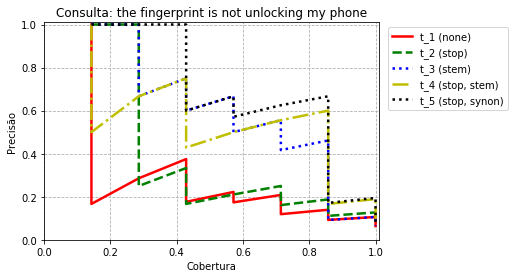

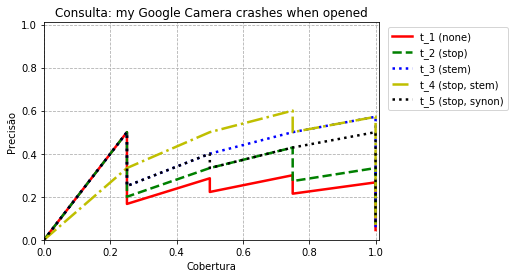

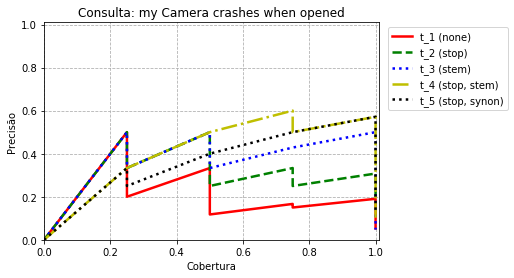

In [20]:
for consulta in consultas:
    generate_graph(consulta)

In [10]:
basic_df = df[basic_columns]

#### Gerando as Matrizes de Resultados sem limitação

In [11]:
cur = df.replace(replace_dict).loc[df['lim_consulta'] ==  120].groupby('consulta')

for key, item in cur:
    print(cur.get_group(key))

                  base                       consulta lim_consulta retornados  \
119         t_1 (none)  my Camera crashes when opened          120         76   
239         t_2 (stop)  my Camera crashes when opened          120         22   
359         t_3 (stem)  my Camera crashes when opened          120         84   
479   t_4 (stop, stem)  my Camera crashes when opened          120         39   
599  t_5 (stop, synon)  my Camera crashes when opened          120         29   

    retornados_relevantes tot_relevantes_existentes  precisão  cobertura  \
119                     4                         4  0.052632        1.0   
239                     4                         4  0.181818        1.0   
359                     4                         4  0.047619        1.0   
479                     4                         4  0.102564        1.0   
599                     4                         4  0.137931        1.0   

           f1  
119  0.100000  
239  0.307692  
359  0.0

In [12]:
# figname = 'clf-f1-2-daneshvar18'
# plt.savefig(f'{figfolder}/{figname}.png', bbox_inches='tight', dpi=figdpi)
# plt.savefig(f'{figfolder}/{figname}-big.png', bbox_inches='tight',dpi=100)

In [13]:
# connection = urllib.request.urlopen('http://localhost:8983/solr/trabalho_1/select?q=fingerprint&wt=json&rows=200')
# response = json.load(connection)
# print(response['response']['numFound'], "documents found.")

# Print the name of each document.

# for document in response['response']['docs']:
#   print("  Name =", document['doc'])